<a href="https://colab.research.google.com/github/Sumalyo/MONN_work/blob/main/Memristor_Tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memristor Modelling


## Memristor Analytics

In [27]:
!pip install schemdraw[svgmath]
!pip install latexify-py

In [51]:
import numpy as np
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
from tabulate import tabulate
import schemdraw
import schemdraw.elements as elm
import sympy as sp

In [59]:
class Memristor:
  def __init__(self) -> None:
    self.g0=5e-3
    self.g1=1700;
    self.Cth=1e-14
    self.gth=0.7e-6
    self.Tamb=300
    self.Rs = 200
  def getMemcondductance(self,T):
    G_T = self.g0 * np.exp(-self.g1 / T) # Calculate the memconductance
    return G_T
  def calculateCurrent(self,Vm,T):
    G = self.getMemcondductance(T)
    Im = Vm * G
    return Im
  def calculateVoltage(self,Im,T):
    G = self.getMemcondductance(T)
    Vm = Im/G
    return Vm
  def ChangeModelVoltage(self,t,T,Vm):
    Im = self.calculateCurrent(Vm,T)
    dTdt = (1/self.Cth)*((Vm * Im)-self.gth*(T-self.Tamb))
    return dTdt
  def ChangeModelCurrent(self,t,T,Im):
    Vm = self.calculateVoltage(Im,T)
    dTdt = (1/self.Cth)*((Vm * Im)-self.gth*(T-self.Tamb))
    return dTdt
  def ChangeModelVoltageFunction(self,t,T,Vfunc,tF):
    Vm = Vfunc(t,tF)
    Im = self.calculateCurrent(Vm,T)
    dTdt = (1/self.Cth)*((Vm * Im)-self.gth*(T-self.Tamb))
    return dTdt
  def ChangeModelVoltageFunctionRs(self,t,T,Vfunc,tF):
    Vm = Vfunc(t,tF)
    G = self.getMemcondductance(T)
    Vm = Vm / (1+(self.Rs * G))
    Im = self.calculateCurrent(Vm,T)
    dTdt = (1/self.Cth)*((Vm * Im)-self.gth*(T-self.Tamb))
    return dTdt
  def ChangeModelCurrentFunction(self,t,T,Ifunc,tF):
    Im = Ifunc(t,tF)
    Vm = self.calculateVoltage(Im,T)
    dTdt = (1/self.Cth)*((Vm * Im)-self.gth*(T-self.Tamb))
    return dTdt
  def getStaticVoltage(self,T):
    G = self.getMemcondductance(T)
    Vm = math.sqrt(self.gth*(T-self.Tamb)/G)
    return Vm
  def getStaticCurrent(self,T):
    G = self.getMemcondductance(T)
    Im = math.sqrt(self.gth*(T-self.Tamb)*G)
    return Im


### DC I-V Plot

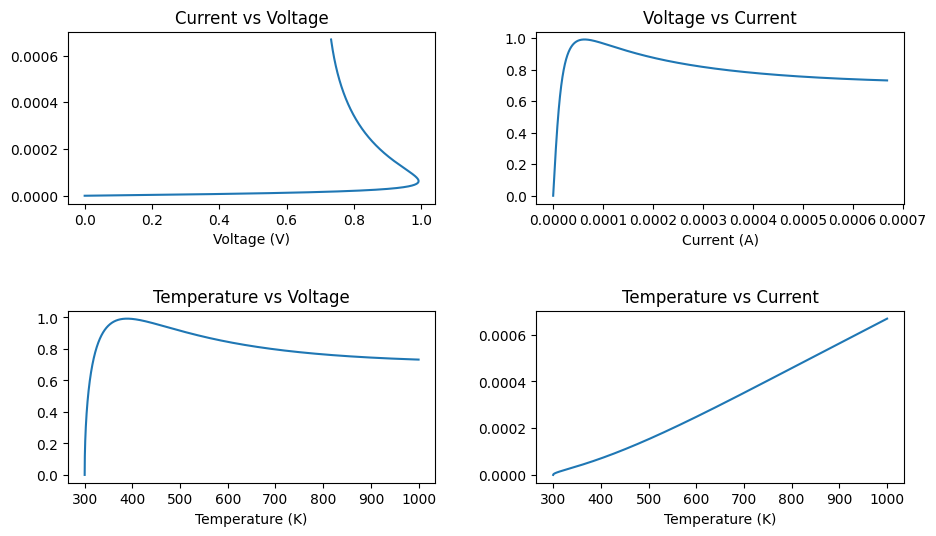

In [3]:
# Range of temperature
T_range = np.linspace(300, 1000, 10000)
V_list = list()
I_list = list()
mem = Memristor()
for T in T_range:
  V_list.append(mem.getStaticVoltage(T))
  I_list.append(mem.getStaticCurrent(T))
# plot I vs V and V vs I
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(V_list, I_list)
plt.title("Current vs Voltage")
plt.xlabel("Voltage (V)")

plt.subplot(2, 2, 2)
plt.plot(I_list, V_list)
plt.title("Voltage vs Current")
plt.xlabel("Current (A)")

# Plot the temperature increasing
plt.subplot(2, 2, 3)
plt.plot(T_range, V_list)
plt.title("Temperature vs Voltage")
plt.xlabel("Temperature (K)")

plt.subplot(2, 2, 4)
plt.plot(T_range, I_list)
plt.title("Temperature vs Current")
plt.xlabel("Temperature (K)")

plt.tight_layout(pad=3.0)
plt.show()

In [78]:

# Define symbols and the function
T = sp.Function('T')(t)
t = sp.symbols('t')
G = sp.symbols('G')
g0 = sp.symbols('g0')
g1 = sp.symbols('g1')
gth = sp.symbols('gth')
Tamb = sp.symbols('Tamb')
Im = sp.symbols('Im')
Vm = sp.symbols('Vm')
Cth = sp.symbols('Cth')
t0 = sp.symbols('t0')
X = sp.symbols('X')

# Write the formula for conductance at T
G_T = sp.Eq(G,g0 * sp.exp(-g1 / T))
display(G_T)
currentExp = sp.Eq(Im,Vm * G)
display(currentExp)
NewtonCool = sp.Eq(Cth * T.diff(t), ((Vm * Im)-gth*(T-Tamb)))
display(NewtonCool)



Eq(G, g0*exp(-g1/T(t)))

Eq(Im, G*Vm)

Eq(Cth*Derivative(T(t), t), Im*Vm - gth*(-Tamb + T(t)))

### Quasi Static Analyis
We can now apply current and voltage sweeps and see the effects of these signals on the device

In [4]:
def sweep_gen_v(t,t_final):
    peak = 1.7
    val = peak*np.sin(np.pi*t/t_final)
    return abs(val)

In [5]:
def sweep_gen_sinv(t,t_final):
    peak = 1
    val = peak*np.sin(2*np.pi*t/t_final)
    return val

In [6]:
def sweep_gen_I_2(t,t_final):
    peak = 0.001
    return peak*np.sin(2*np.pi*t/6)

Text(0, 0.5, 'Voltage (V)')

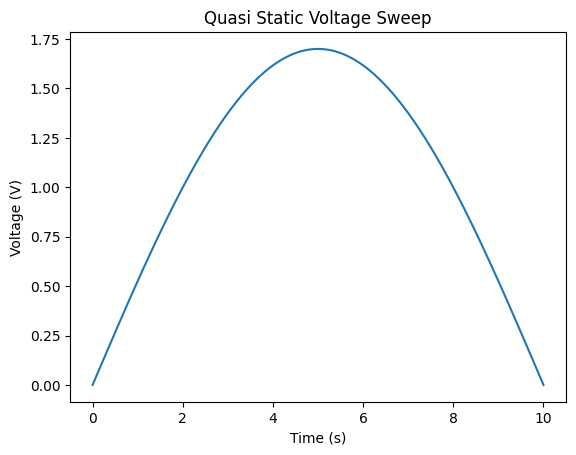

In [7]:
#plot sweeo_gen_v
t_final = 10
t_span = (0, t_final)
t_eval = np.linspace(0, t_final, 1000)
plt.plot(t_eval, [sweep_gen_v(ti,t_final) for ti in t_eval])
plt.title("Quasi Static Voltage Sweep")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")

In [8]:
def sweep_gen_I(t,t_final):
    peak = 0.003
    if t < t_final / 2:
        return (peak / (t_final / 2)) * t
    else:
        return peak - (peak / (t_final / 2)) * (t - t_final / 2)

In [9]:
def sweep_gen_I_1(t,t_final):
    peak = 0.003
    if t < t_final:
        return (peak / (t_final)) * t

#### Voltage Sweep

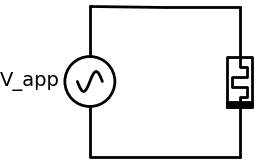

In [98]:
# Draw the circuit

with schemdraw.Drawing():
  elm.Line().right()
  elm.Memristor().up()
  elm.Line().left()
  elm.SourceSin().down().label("V_app")


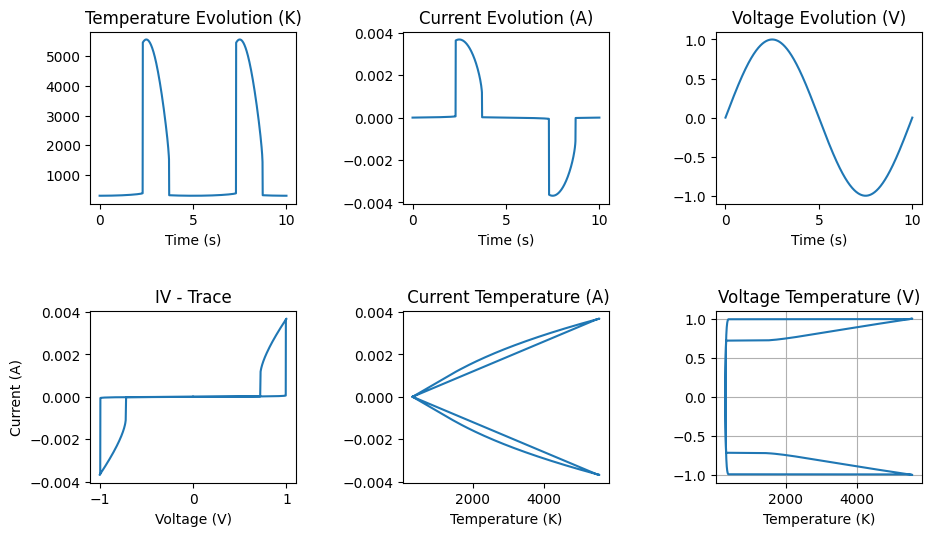

In [10]:
mem = Memristor()
t_final = 10
t_span = (0, t_final)
t_eval = np.linspace(0, t_final, 1000)
sol = solve_ivp(mem.ChangeModelVoltageFunction, t_span, [301], t_eval=t_eval, args=(sweep_gen_sinv,t_final,),method='Radau')

# Post-process results
T_final = sol.y[0]
V_app_final = np.array([sweep_gen_sinv(ti,t_final) for ti in sol.t])
G_final = mem.getMemcondductance(T_final)
Vm_final = V_app_final
Im_final = Vm_final * G_final
plt.figure(figsize=(10, 6))
# plt.plot(Vm_final, Im_final, label='I-V Trace')
# plt.title("Quasi Static I-V Characteristic for Voltage Sweep")
# plt.xlabel("Memristor Voltage (Vm)")
# plt.ylabel("Memristor Current (Im)")
# Plot I-V trace , T-t trace, V-t trace, I-t trace, I-T trace and V-T trace as subplots
plt.subplot(2, 3, 1)
plt.plot(sol.t, T_final)
plt.title("Temperature Evolution (K)")
plt.xlabel("Time (s)")

plt.subplot(2, 3, 2)
plt.plot(sol.t, Im_final)
plt.title("Current Evolution (A)")
plt.xlabel("Time (s)")

plt.subplot(2, 3, 3)
plt.plot(sol.t, Vm_final)
plt.title("Voltage Evolution (V)")
plt.xlabel("Time (s)")

plt.subplot(2, 3, 4)
plt.plot(Vm_final,Im_final)
plt.title("IV - Trace")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")

plt.subplot(2, 3, 5)
plt.plot(T_final,Im_final)
plt.title(" Current Temperature (A)")
plt.xlabel("Temperature (K)")

plt.subplot(2, 3, 6)
plt.plot(T_final,Vm_final)
plt.title("Voltage Temperature (V)")
plt.xlabel("Temperature (K)")

plt.grid(True)
plt.tight_layout(pad=3.0)
plt.show()

#### Current Sweep

/usr/local/lib/python3.12/dist-packages/scipy/integrate/_ivp/radau.py:120: RuntimeWarning: invalid value encountered in scalar divide
  rate = dW_norm / dW_norm_old


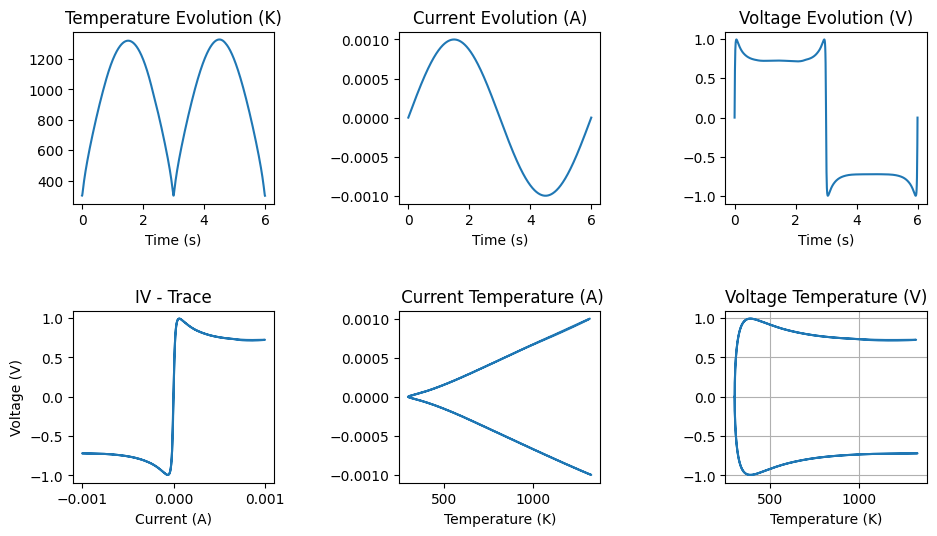

In [11]:
mem = Memristor()
t_final = 6
t_span = (0, t_final)
t_eval = np.linspace(0, t_final, 1000)
sol = solve_ivp(mem.ChangeModelCurrentFunction, t_span, [301], t_eval=t_eval, args=(sweep_gen_I_2,t_final,),method='Radau')

# Post-process results
T_final = sol.y[0]
Im_final = np.array([sweep_gen_I_2(ti,t_final) for ti in sol.t])
G_final = mem.getMemcondductance(T_final)
Vm_final = Im_final/G_final
# Im_final = Vm_final * G_final
plt.figure(figsize=(10, 6))
# plt.plot(Vm_final, Im_final, label='I-V Trace')
# plt.title("Quasi Static I-V Characteristic for Voltage Sweep")
# plt.xlabel("Memristor Voltage (Vm)")
# plt.ylabel("Memristor Current (Im)")
# Plot I-V trace , T-t trace, V-t trace, I-t trace, I-T trace and V-T trace as subplots
plt.subplot(2, 3, 1)
plt.plot(sol.t, T_final)
plt.title("Temperature Evolution (K)")
plt.xlabel("Time (s)")

plt.subplot(2, 3, 2)
plt.plot(sol.t, Im_final)
plt.title("Current Evolution (A)")
plt.xlabel("Time (s)")

plt.subplot(2, 3, 3)
plt.plot(sol.t, Vm_final)
plt.title("Voltage Evolution (V)")
plt.xlabel("Time (s)")

plt.subplot(2, 3, 4)
plt.plot(Im_final,Vm_final)
plt.title("IV - Trace")
plt.xlabel("Current (A)")
plt.ylabel("Voltage (V)")

plt.subplot(2, 3, 5)
plt.plot(T_final,Im_final)
plt.title(" Current Temperature (A)")
plt.xlabel("Temperature (K)")

plt.subplot(2, 3, 6)
plt.plot(T_final,Vm_final)
plt.title("Voltage Temperature (V)")
plt.xlabel("Temperature (K)")

plt.grid(True)
plt.tight_layout(pad=3.0)
plt.show()

## Memristor with Resistor in series

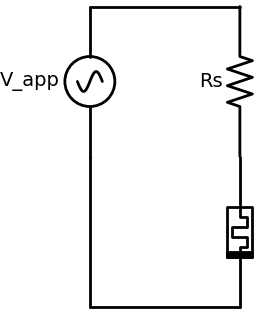

In [104]:
with schemdraw.Drawing():
  elm.Line().right()
  elm.Memristor().up()
  elm.Resistor().up().label('Rs')
  elm.Line().left()
  elm.SourceSin().down().label("V_app")
  elm.Line().down()

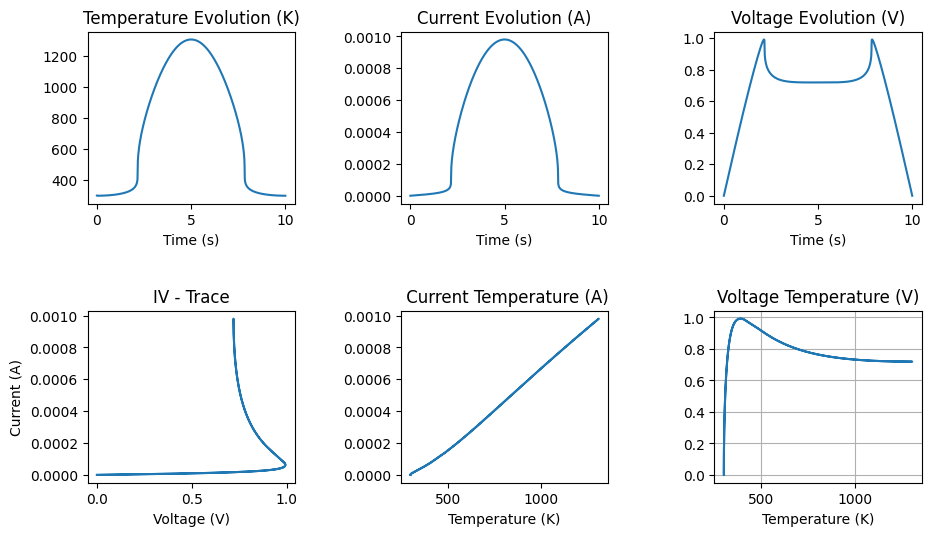

In [12]:
mem = Memristor()
mem.Rs = 1000
t_final = 10
t_span = (0, t_final)
t_eval = np.linspace(0, t_final, 1000)
sol = solve_ivp(mem.ChangeModelVoltageFunctionRs, t_span, [301], t_eval=t_eval, args=(sweep_gen_v,t_final,),method='Radau')

# Post-process results
T_final = sol.y[0]
V_app_final = np.array([sweep_gen_v(ti,t_final) for ti in sol.t])
G_final = mem.getMemcondductance(T_final)
Vm_final = V_app_final /(1+mem.Rs * G_final)
Im_final = Vm_final * G_final
plt.figure(figsize=(10, 6))

plt.subplot(2, 3, 1)
plt.plot(sol.t, T_final)
plt.title("Temperature Evolution (K)")
plt.xlabel("Time (s)")

plt.subplot(2, 3, 2)
plt.plot(sol.t, Im_final)
plt.title("Current Evolution (A)")
plt.xlabel("Time (s)")

plt.subplot(2, 3, 3)
plt.plot(sol.t, Vm_final)
plt.title("Voltage Evolution (V)")
plt.xlabel("Time (s)")

plt.subplot(2, 3, 4)
plt.plot(Vm_final,Im_final)
plt.title("IV - Trace")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")

plt.subplot(2, 3, 5)
plt.plot(T_final,Im_final)
plt.title(" Current Temperature (A)")
plt.xlabel("Temperature (K)")

plt.subplot(2, 3, 6)
plt.plot(T_final,Vm_final)
plt.title("Voltage Temperature (V)")
plt.xlabel("Temperature (K)")

plt.grid(True)
plt.tight_layout(pad=3.0)
plt.show()

Text(0.5, 0, 'Time (s)')

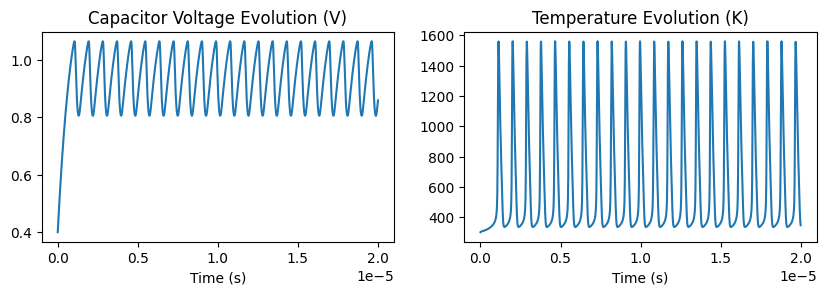

In [13]:
class MemristorCell:
    def __init__(self, memristor_instance) -> None:
        self.mem = memristor_instance
        self.Vb = 1.5
        self.Rb = 2e3       # Biasing resistor
        self.C   = 0.5e-9      # Capacitor 1 or
        self.Rs = 200       # Series resistor

    def getCellDynamics(self, t, y):
        T, Vc = y  # State variables: Temperature and Capacitor Voltage

        # 1. Memristor Branch Current
        G = self.mem.getMemcondductance(T)
        # Total resistance of the branch is Rm + Rs
        # Im = Vc / (Rm + Rs) -> Im = Vc / (1/G + Rs)
        Im = Vc / ((1/G) + self.Rs)

        # 2. Voltage across the memristor itself (Vm)
        Vm = Im / G

        # 3. ODE for Temperature (from your original logic)
        dTdt = (1/self.mem.Cth) * ((Vm * Im) - self.mem.gth * (T - self.mem.Tamb))

        # 4. ODE for Capacitor Voltage
        # Ic = I_bias - I_mem
        dVcdt = (1/self.C) * ((self.Vb - Vc)/self.Rb - Im)

        return [dTdt, dVcdt]

# --- Simulation ---
mem = Memristor() # Your original Memristor class
cell = MemristorCell(mem)

# Initial conditions: T = 300K, Vc = 0V
y0 = [301, 0.4]
t_span = (0, 20e-6) # 20 microseconds
t_eval = np.linspace(0, 20e-6, 2000)

sol = solve_ivp(cell.getCellDynamics, t_span, y0, t_eval=t_eval, method='Radau')

# Post-processing for Current
T_sol = sol.y[0]
Vc_sol = sol.y[1]
G_sol = mem.getMemcondductance(T_sol)
Im_sol = Vc_sol / ((1/G_sol) + cell.Rs)

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(sol.t, Vc_sol)
plt.title("Capacitor Voltage Evolution (V)")
plt.xlabel("Time (s)")

plt.subplot(2, 2, 2)
plt.plot(sol.t, T_sol)
plt.title("Temperature Evolution (K)")
plt.xlabel("Time (s)")

As expected we do clearly see the oscillatory pattern for voltage Vc and current spikes through the memristor device

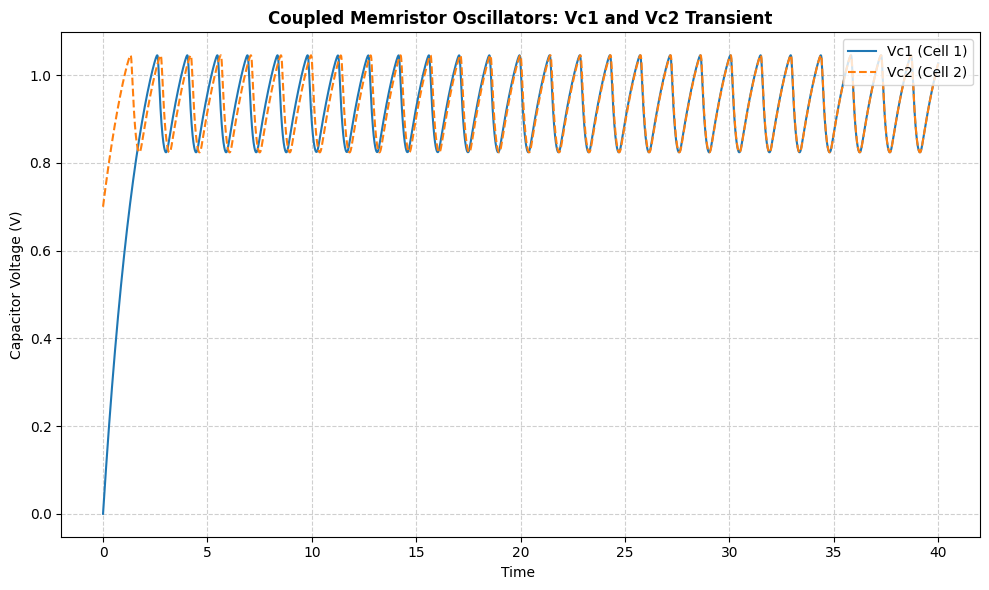

In [14]:
class CoupledMemristorCells:
    def __init__(self, memristor_instance,Rcouple = 10000,Ccouple= 1e-9):
        self.mem = memristor_instance
        self.Vb = 1.5
        self.Rb = 2e3
        self.Rs = 200
        self.C = 1e-9

        # Coupling Parameters
        self.Rcouple = Rcouple  # Coupling resistance
        self.Ccouple = Ccouple  # Coupling capacitance

    def dynamics(self, t, y):
        # State vector y: [T1, Vc1, T2, Vc2, Vcc]
        T1, Vc1, T2, Vc2, Vcc = y

        # Cell 1 Calculations
        G1 = self.mem.getMemcondductance(T1)
        Im1 = Vc1 / ((1/G1) + self.Rs)
        Vm1 = Im1 / G1

        # Cell 2 Calculations
        G2 = self.mem.getMemcondductance(T2)
        Im2 = Vc2 / ((1/G2) + self.Rs)
        Vm2 = Im2 / G2


        # Coupling Current
        I_cp = (Vc1 - Vc2 - Vcc) / self.Rcouple
        # Implement Support for Time switching
        if t < 8e-6:
            I_cp = 0.000

        vb1 = self.Vb
        vb2 = self.Vb

        # if t < 5e-6:
        #     vb1 = 0
        #     #Vc1 = 0

        # ODEs for Cell 1
        dT1dt = (1/self.mem.Cth) * ((Vm1 * Im1) - self.mem.gth * (T1 - self.mem.Tamb))
        dVc1dt = (1/self.C) * ((self.Vb-Vc1)/self.Rb - Im1 - I_cp)

        # ODEs for Cell 2
        dT2dt = (1/self.mem.Cth) * ((Vm2 * Im2) - self.mem.gth * (T2 - self.mem.Tamb))
        dVc2dt = (1/self.C) * ((self.Vb-Vc2)/self.Rb - Im2 + I_cp)

        # ODE for Coupling Capacitor
        dVccdt = I_cp / self.Ccouple

        return [dT1dt, dVc1dt, dT2dt, dVc2dt, dVccdt]

    def dynamicsNoCap(self, t, y):
        # State vector y: [T1, Vc1, T2, Vc2, Vcc]
        T1, Vc1, T2, Vc2 = y

        # Cell 1 Calculations
        G1 = self.mem.getMemcondductance(T1)
        Im1 = Vc1 / ((1/G1) + self.Rs)
        Vm1 = Im1 / G1

        # Cell 2 Calculations
        G2 = self.mem.getMemcondductance(T2)
        Im2 = Vc2 / ((1/G2) + self.Rs)
        Vm2 = Im2 / G2


        # Coupling Current
        I_cp = (Vc1 - Vc2) / self.Rcouple
        # Implement Support for Time switching

        if t < 10e-6:
            I_cp = 0.000

        vb1 = self.Vb
        vb2 = self.Vb

        # if t < 5e-6:
        #     vb1 = 0
        #     #Vc1 = 0

        # ODEs for Cell 1
        dT1dt = (1/self.mem.Cth) * ((Vm1 * Im1) - self.mem.gth * (T1 - self.mem.Tamb))
        dVc1dt = (1/self.C) * ((self.Vb-Vc1)/self.Rb - Im1 - I_cp)

        # ODEs for Cell 2
        dT2dt = (1/self.mem.Cth) * ((Vm2 * Im2) - self.mem.gth * (T2 - self.mem.Tamb))
        dVc2dt = (1/self.C) * ((self.Vb-Vc2)/self.Rb - Im2 + I_cp)


        return [dT1dt, dVc1dt, dT2dt, dVc2dt]

# --- Simulation ---
mem = Memristor()
coupled_system = CoupledMemristorCells(mem,Rcouple = 10000,Ccouple= 1e-9)

# Initial conditions: T1 = T2 = 300K, Vc1 = Vc2 = 0V
# [T1, Vc1, T2, Vc2, Vcc]
y0 = [301, 0.0, 301, 0.0, 0.0]
y0R = [301, 0.0, 301, 0.7]
t_span = (0, 40e-6)
t_eval = np.linspace(0, 40e-6, 5000)

#sol = solve_ivp(coupled_system.dynamics, t_span, y0, t_eval=t_eval, method='Radau')
sol = solve_ivp(coupled_system.dynamicsNoCap, t_span, y0R, t_eval=t_eval, method='RK23')

plt.figure(figsize=(10, 6))
plt.plot(sol.t * 1e6, sol.y[1], label='Vc1 (Cell 1)', color='tab:blue', linewidth=1.5)
plt.plot(sol.t * 1e6, sol.y[3], label='Vc2 (Cell 2)', color='tab:orange', linewidth=1.5, linestyle='--')
plt.title("Coupled Memristor Oscillators: Vc1 and Vc2 Transient", fontweight='bold')
plt.xlabel("Time ")
plt.ylabel("Capacitor Voltage (V)")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [15]:
def investigateFinalPhase(R=10000):
    mem = Memristor()
    coupled_system = CoupledMemristorCells(mem, Rcouple=R,Ccouple=1e-9)

    # Note: Added a slight perturbation to initial Vc2 to break symmetry
    # if you want to observe how they settle into phase.
    y0R = [300, 0.0, 300, 0.9]
    y0 = [300, 0.0, 300, 0.7, 0.0]
    t_span = (0, 50e-6)
    t_eval = np.linspace(0, 50e-6, 10000)

    #sol = solve_ivp(coupled_system.dynamics, t_span, y0, t_eval=t_eval, method='Radau')
    sol = solve_ivp(coupled_system.dynamicsNoCap, t_span, y0R, t_eval=t_eval, method='RK23')


    # Filter for time > 30e-6
    mask = sol.t >= 30e-6
    t_steady = sol.t[mask]
    Vc1 = sol.y[1][mask]
    Vc2 = sol.y[3][mask] # Index 3 is Vc2 in dynamicsNoCap

    # Find peaks to determine period and phase lag
    peaks1, _ = find_peaks(Vc1)
    peaks2, _ = find_peaks(Vc2)

    if len(peaks1) < 2 or len(peaks2) < 2:
        return "Insufficient oscillations to determine phase."

    # Calculate Period (T) from Cell 1
    period = np.mean(np.diff(t_steady[peaks1]))

    # Calculate Time Delay (dt) between nearest peaks
    # We find the average difference between corresponding peak times
    min_len = min(len(peaks1), len(peaks2))
    time_delay = np.mean(t_steady[peaks1[:min_len]] - t_steady[peaks2[:min_len]])

    # Phase difference in degrees: (dt / T) * 360
    phase_diff = (time_delay / period) * 360 % 360
    if phase_diff > 180: phase_diff -= 360 # Wrap to [-180, 180]

    return phase_diff

def run_phase_investigation(r_list):
    results = []

    for r in r_list:
        try:
            # We call the function defined in the previous step
            phase = investigateFinalPhase(R=r)

            # Formatting the output for the table
            if isinstance(phase, str):
                results.append([r, phase])
            else:
                results.append([r, f"{phase:.2f}°"])
        except Exception as e:
            results.append([r, f"Error: {str(e)}"])

    return results

# Defining your list
R_List = [i*1000 for i in range(4,25)]

# Generate and display table
table_data = run_phase_investigation(R_List)
print(tabulate(table_data, headers=["R_couple (Ω)", "Final Phase Diff"], tablefmt="grid"))

+----------------+--------------------+
|   R_couple (Ω) | Final Phase Diff   |
+================+====================+
|           4000 | 0.00°              |
+----------------+--------------------+
|           5000 | 0.09°              |
+----------------+--------------------+
|           6000 | 0.27°              |
+----------------+--------------------+
|           7000 | 0.54°              |
+----------------+--------------------+
|           8000 | 0.89°              |
+----------------+--------------------+
|           9000 | 1.88°              |
+----------------+--------------------+
|          10000 | 2.77°              |
+----------------+--------------------+
|          11000 | 4.11°              |
+----------------+--------------------+
|          12000 | 5.63°              |
+----------------+--------------------+
|          13000 | 7.06°              |
+----------------+--------------------+
|          14000 | 8.67°              |
+----------------+--------------------+
